In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


- Code taken from: https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201804KnowledgeSpilloversRep/3b-RegCoefficients-0508.ipynb

In [2]:
pathdir = "DataStore/2018-10/Reg1016/"
reg_f = "reg_model_1016.pkl"

regs = pickle.load(open(pathdir+reg_f, "rb"))

# Model names to equations
regs["model_names_eqn"] = dict(zip(regs["model_names"].tolist(), regs["model_names"].index.tolist()))

In [3]:
# JTH Rep
jr = pd.read_csv("DataStore/2018-07-P3/JTHReg0727/JTH_res_out_0726.csv",index_col=0)
jr.loc[jr["index"] == "$I(MSA \, Match)$", "index"] = "C(inv_msa_match)[T.True]"

# FE results (0930 - uses full dataset) and Sim results (1003 - uses only those with sim pc, sim pc msa values)
rr = pd.read_csv("DataStore/2018-10/Reg1016/reg_pairs_out_HC1_1016.csv",index_col=0)

# Use reg_model_1002 to assign model numbers
rr["Model Num"] = rr["Model"].map(regs["model_names_eqn"])

# Get rid of models without a number (squared ones excluded from analysis)
print(len(rr))
rr = rr.loc[rr["Model Num"].notnull()]
print(len(rr))
rr["samp"] = rr["samp"].apply(eval)
rr = pd.concat([jr,rr],axis=0)
# Reset index
rr = rr.reset_index(drop=True)
# Integer model number
rr["Model Num"] = rr["Model Num"].astype(int)
# Equation id
rr["id"] = ["({0}, {1}, {2})".format(i,j,k) for i,j,k in zip(rr["samp"], rr["LKS"], rr["Model"])]
rr["id"] = rr["id"].astype(str)

# Add S.E.
# S.E. index
se_ind = rr.loc[rr["index"].isnull()].index.tolist()

for ind in se_ind:
    rr.loc[ind, "index"] = "SE {0}".format(rr.loc[ind-1, "index"])

4512
4512


In [63]:
# Regression models
# Primclass
rm_pc = [
    # JTH norm percentage match PC FE
    "(JTH Rep, norm_perc_match_10, N Perc Match Targ MSA, PC FE)",
    # pcc N PC FE
#     "(('tp_pct_common_cited', 'primclass'), norm_tp_pct_common_cited, N PC FE)",
    # docvecs N PC FE
    "(('docvecs', 'primclass'), norm_sim_docvecs, N PC FE-Year FE)",
    # sim pc MSA N All FE
    "(('docvecs', 'primclass'), norm_sim_docvecs, N Exam FE-Sim PC MSA)"    
]

# rm_pc_n = ["Citations Benchmark", "Pct Common Cited Pats", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC MSA"]
rm_pc_n = ["Citations Benchmark", "Sim, PC FE", "Sim, PC Prox", "Sim, PC MSA Prox"]

# NAICS
rm_n = [
    # JTH norm percentage match PC FE
    "(JTH Rep, norm_perc_match_10, N Perc Match Targ MSA, PC FE)",
    # pcc N PC FE
#     "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC FE)",
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC FE-Year FE)",
    # sim pc N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC)",
    # sim pc MSA N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC MSA)"    
]

rm_d = dict(zip(rm_pc, rm_pc_n))
rm_d.update(dict(zip(rm_n, rm_n_n)))


### Primclass sample

In [51]:
# Localization estimates
rc = rr.loc[rr["id"].isin(rm_pc) & rr["index"].isin(["C(inv_msa_match)[T.True]", "SE C(inv_msa_match)[T.True]"])]

# Strip punctuation
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[:6]))

rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[1:7]))

# New id
rc["id"] = rc["id"].map(rm_d)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [52]:
# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


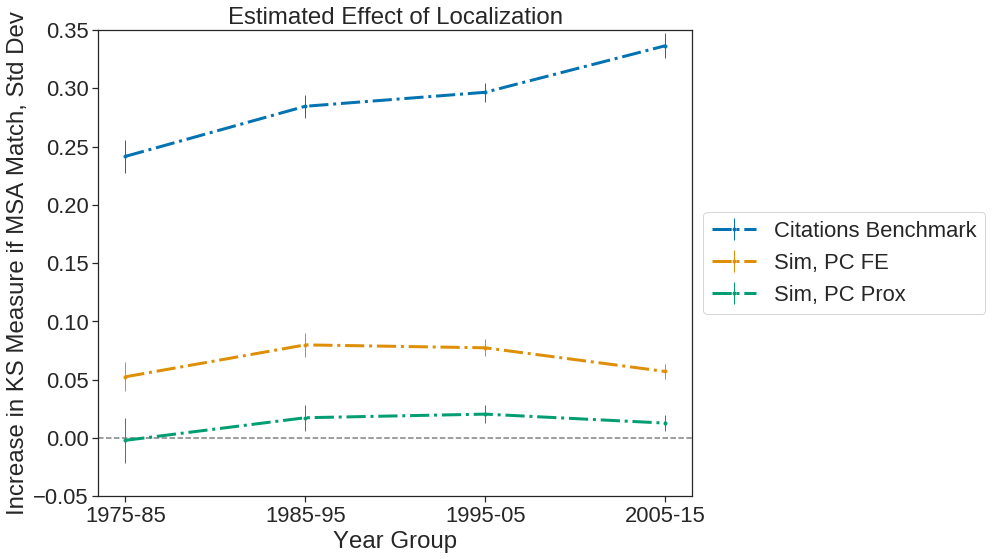

In [53]:
%matplotlib inline
sns.set(font_scale=2)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')
# plt.rcParams.update({'figure.autolayout': True})

d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 0.35

fig, ax = plt.subplots(figsize=(14,8))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 1, 
                    linewidth = 3, color = cpal[n], label = n, data = d2.get_group(n).copy())
    
# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Localization")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in KS Measure if MSA Match, Std Dev")
ax.set_ylim(y_min, y_max)

plt.savefig("DataStore/2018-10/ResultsGraphs/pc_local_est.png")
plt.show()

### NAICS Sample

In [58]:
# Localization estimates
rc = rr.loc[rr["id"].isin(rm_n) & rr["index"].isin(["C(inv_msa_match)[T.True]", "SE C(inv_msa_match)[T.True]"])]

# Strip punctuation
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[:6]))

rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[1:7]))

# New id
rc["id"] = rc["id"].map(rm_d)

# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


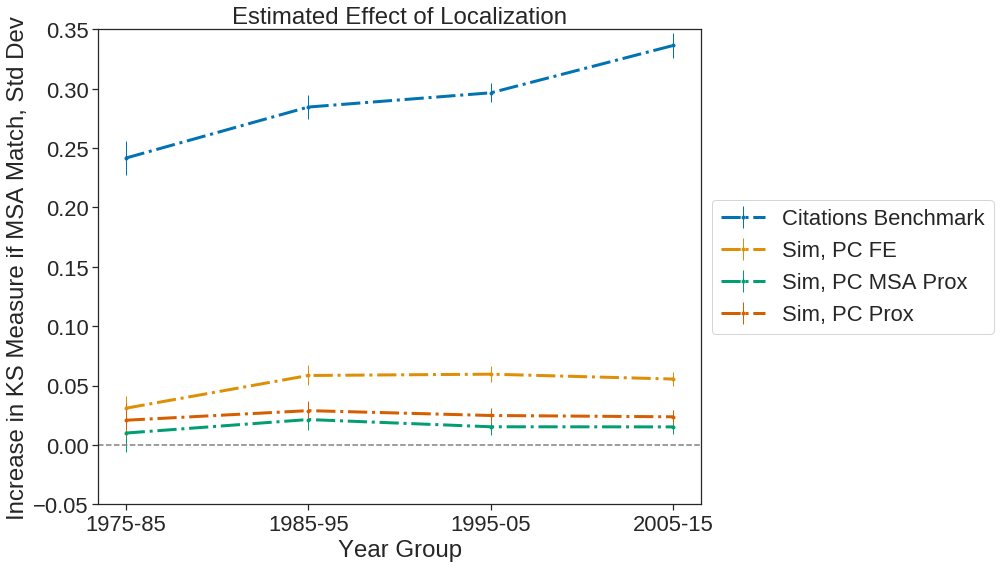

In [59]:
%matplotlib inline

d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 0.35

fig, ax = plt.subplots(figsize=(14,8))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 1, 
                    linewidth = 3, color = cpal[n], label = n, data = d2.get_group(n).copy())
    
# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Localization")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in KS Measure if MSA Match, Std Dev")
ax.set_ylim(y_min, y_max)

plt.savefig("DataStore/2018-10/ResultsGraphs/naics_local_est.png")
plt.show()

### NAICS Sample - Other Match Estimates

In [46]:
# rm_n_n = ["Citations Benchmark", "Pct Common Cited Pats", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC", "Sim DocVecs, Sim PC MSA"]
rm_n_n = ["Citations Benchmark", "Sim, PC FE", "Sim, PC Prox", "Sim, PC MSA Prox"]

# Other match
rm_n_o = [
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC FE-Year FE)",
    # sim pc N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Inv M)",
    # sim pc MSA N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M)"    
]

rm_n_o_n = ["MSA Match Est", "Inv Match Est", "PC Match Est"]
rm_d.update(dict(zip(rm_n_o, rm_n_o_n)))

# Match estimates
rc = rr.loc[rr["id"].isin(rm_n_o)]

# Replace all match variables
rc["index"] = rc["index"].apply(lambda x: x.replace("common_pat_inv", "inv_msa_match")\
.replace("primclass_match", "inv_msa_match"))

# Strip punctuation
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[:6]))

rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[1:7]))

# New id
rc["id"] = rc["id"].map(rm_d)

# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


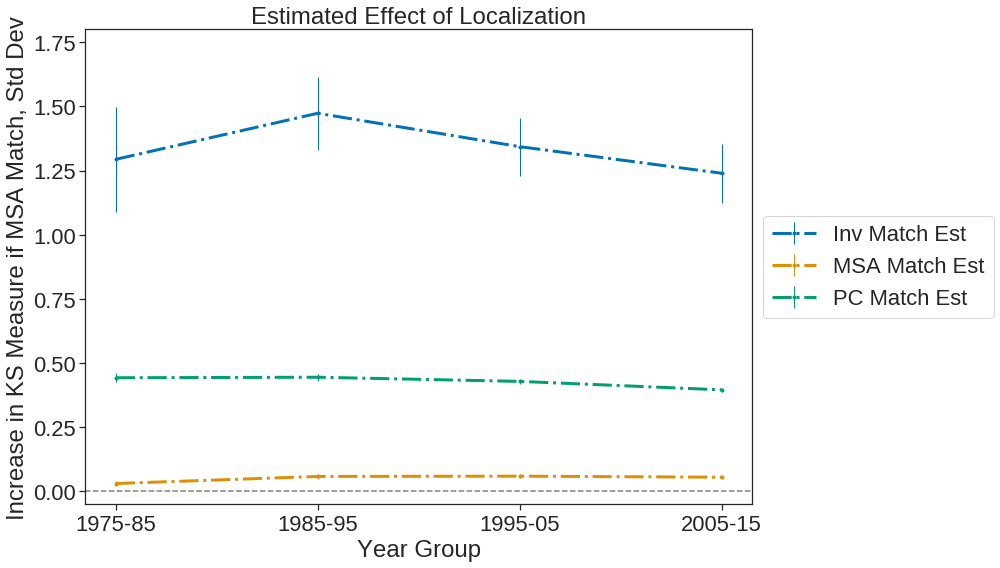

In [47]:
%matplotlib inline
d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 1.8

fig, ax = plt.subplots(figsize=(14,8))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 1, 
                    linewidth = 3, color = cpal[n], label = n, data = d2.get_group(n).copy())
    
# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Localization")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in KS Measure if MSA Match, Std Dev")
ax.set_ylim(y_min, y_max)

plt.savefig("DataStore/2018-10/ResultsGraphs/naics_other_est.png")
plt.show()

### Other match variables

#### 1. First set of match variables
Similarity

In [12]:
# Regression models
# NAICS
rm_n = [
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC FE-Year FE)",
    # sim pc N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Inv M)",
    # sim pc MSA N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M)"    
]

In [13]:
m_vars = ["C(inv_msa_match)[T.True]", "C(common_pat_inv)[T.True]", "C(primclass_match)[T.True]", 
          "C(examiner_match)[T.True]", "C(lawyer_match)[T.True]"]
m_vars = m_vars+["SE "+c for c in m_vars]

In [14]:
rc = rr.loc[rr["id"].isin(rm_n)]
# rc2 = rc.loc[rc["index"].apply(lambda x: "[T.True]" in x)]
rc2 = rc.loc[rc["index"].isin(m_vars)]
rc2 = rc2[["index", "1975-85", "1985-95", "1995-05", "2005-15", ]]
rc2["index"] = ["$I(MSA \,Match)$", "S.E.", "$I(Inv \,Match)$", "S.E.", "$I(Primclass \,Match)$", "S.E."]
rc2 = rc2.rename(columns={"index": ""})
print(rc2.to_latex(index=False, escape=False, column_format = "lcccc"))

\begin{tabular}{lcccc}
\toprule
                        &    1975-85 &    1985-95 &    1995-05 &    2005-15 \\
\midrule
       $I(MSA \,Match)$ &  0.0309*** &  0.0585*** &  0.0596*** &  0.0555*** \\
                   S.E. &   (0.0053) &   (0.0043) &   (0.0034) &   (0.0030) \\
       $I(Inv \,Match)$ &  1.2938*** &  1.4733*** &  1.3431*** &  1.2396*** \\
                   S.E. &   (0.1045) &   (0.0727) &   (0.0576) &   (0.0585) \\
 $I(Primclass \,Match)$ &  0.4430*** &  0.4450*** &  0.4288*** &  0.3958*** \\
                   S.E. &   (0.0086) &   (0.0066) &   (0.0050) &   (0.0043) \\
\bottomrule
\end{tabular}



PCC

In [8]:
# Regression models
# NAICS
rm_n = [
    # docvecs N PC FE
    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC FE-Year FE)",
    # sim pc N All FE
    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Inv M)",
    # sim pc MSA N All FE
    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC M)"    
]

m_vars = ["C(inv_msa_match)[T.True]", "C(common_pat_inv)[T.True]", "C(primclass_match)[T.True]", 
          "C(examiner_match)[T.True]", "C(lawyer_match)[T.True]"]
m_vars = m_vars+["SE "+c for c in m_vars]

rc = rr.loc[rr["id"].isin(rm_n)]
# rc2 = rc.loc[rc["index"].apply(lambda x: "[T.True]" in x)]
rc2 = rc.loc[rc["index"].isin(m_vars)]
rc2 = rc2[["index", "1975-85", "1985-95", "1995-05", "2005-15", ]]
rc2["index"] = ["$I(MSA \,Match)$", "S.E.", "$I(Inv \,Match)$", "S.E.", "$I(Primclass \,Match)$", "S.E."]
rc2 = rc2.rename(columns={"index": ""})
print(rc2.to_latex(index=False, escape=False, column_format = "lcccc"))

\begin{tabular}{lcccc}
\toprule
                        &    1975-85 &     1985-95 &     1995-05 &     2005-15 \\
\midrule
       $I(MSA \,Match)$ &  0.0321*** &   0.0737*** &   0.0802*** &   0.0689*** \\
                   S.E. &   (0.0056) &    (0.0075) &    (0.0064) &    (0.0050) \\
       $I(Inv \,Match)$ &  6.5188*** &  11.5080*** &  11.1559*** &  13.5868*** \\
                   S.E. &   (1.2658) &    (1.2087) &    (1.0188) &    (1.0808) \\
 $I(Primclass \,Match)$ &  0.1241*** &   0.2021*** &   0.1994*** &   0.1813*** \\
                   S.E. &   (0.0157) &    (0.0175) &    (0.0132) &    (0.0103) \\
\bottomrule
\end{tabular}



#### 2. Lawyer and examiner match
Docvecs

Accounting for similarity in primary class reduces effect of examiner a lot - examiners must get patents from similar tech areas; more of an effect than for lawyers

In [67]:
rc

,1975-85,1985-95,1995-05,2005-15,LKS,Model,Model Num,index,samp,id
1458,0.0634***,0.0349***,0.0444***,0.0537***,norm_sim_docvecs,N PC M-Sim PC,103,C(common_est_inv)[T.1.0],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1459,(0.0170),(0.0084),(0.0052),(0.0037),norm_sim_docvecs,N PC M-Sim PC,103,SE C(common_est_inv)[T.1.0],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1460,0.8686***,1.0195***,0.9092***,0.8274***,norm_sim_docvecs,N PC M-Sim PC,103,C(common_pat_inv)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1461,(0.1431),(0.0691),(0.0555),(0.0571),norm_sim_docvecs,N PC M-Sim PC,103,SE C(common_pat_inv)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1462,0.1334***,0.1555***,0.0897***,0.0769***,norm_sim_docvecs,N PC M-Sim PC,103,C(examiner_match)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1463,(0.0249),(0.0161),(0.0181),(0.0205),norm_sim_docvecs,N PC M-Sim PC,103,SE C(examiner_match)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1464,0.0208***,0.0289***,0.0248***,0.0237***,norm_sim_docvecs,N PC M-Sim PC,103,C(inv_msa_match)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1465,(0.0071),(0.0042),(0.0033),(0.0030),norm_sim_docvecs,N PC M-Sim PC,103,SE C(inv_msa_match)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1466,0.1884***,0.1460***,0.2362***,0.1811***,norm_sim_docvecs,N PC M-Sim PC,103,C(lawyer_match)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."
1467,(0.0468),(0.0256),(0.0271),(0.0260),norm_sim_docvecs,N PC M-Sim PC,103,SE C(lawyer_match)[T.True],"(docvecs, naics_name)","(('docvecs', 'naics_name'), norm_sim_docvecs, ..."


In [4]:
# Regression models
repl1 = pickle.load(open("DataStore/2018-07-P3/reg_names_dict.pkl", "rb"))
# NAICS
rm_n = [
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Lawyer M)",
    # sim pc N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Examiner M)",
    # sim pc MSA N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-Sim PC)"
]

m_vars = ["C(examiner_match)[T.True]", "C(lawyer_match)[T.True]"]
m_vars = m_vars+["SE "+c for c in m_vars]
m_vars = m_vars+["$N$", "Adjusted $R^2$"]
rc = rr.loc[rr["id"].isin(rm_n)]
# rc2 = rc.loc[rc["index"].apply(lambda x: "[T.True]" in x)]
rc2 = rc.loc[rc["index"].isin(m_vars)]
rc2 = rc2[["index", "1975-85", "1985-95", "1995-05", "2005-15", ]]
rc2["index"] = rc2["index"].apply(lambda x: "S.E." if "SE "in x else x)
rc2["index"] = rc2["index"].apply(lambda x: repl1[x] if x in repl1.keys() else x)
rc2 = rc2.rename(columns={"index": ""})
print(rc2.to_latex(index=False, escape=False, column_format = "lcccc"))

\begin{tabular}{lcccc}
\toprule
                        &    1975-85 &    1985-95 &    1995-05 &    2005-15 \\
\midrule
 $I(Examiner \, Match)$ &  0.1334*** &  0.1555*** &  0.0897*** &  0.0769*** \\
                   S.E. &   (0.0249) &   (0.0161) &   (0.0181) &   (0.0205) \\
    $I(Lawyer \,Match)$ &  0.1884*** &  0.1460*** &  0.2362*** &  0.1811*** \\
                   S.E. &   (0.0468) &   (0.0256) &   (0.0271) &   (0.0260) \\
                    $N$ &     102330 &     280954 &     437386 &     563865 \\
         Adjusted $R^2$ &       0.11 &       0.12 &       0.12 &       0.08 \\
    $I(Lawyer \,Match)$ &  0.2720*** &  0.3721*** &  0.4429*** &  0.3694*** \\
                   S.E. &   (0.0366) &   (0.0281) &   (0.0299) &   (0.0276) \\
                    $N$ &     192773 &     280962 &     437405 &     563881 \\
         Adjusted $R^2$ &       0.06 &       0.07 &       0.08 &       0.05 \\
 $I(Examiner \, Match)$ &  0.4571*** &  0.4867*** &  0.4170*** &  0.4158*** \\
           

In [5]:
# Regression models
# NAICS
rm_n = [
    # docvecs N PC FE
    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Lawyer M)",
    # sim pc N All FE
    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N Examiner M)",
    # sim pc MSA N All FE
    "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC M-Sim PC)"    
]

m_vars = ["C(examiner_match)[T.True]", "C(lawyer_match)[T.True]"]
m_vars = m_vars+["SE "+c for c in m_vars]

rc = rr.loc[rr["id"].isin(rm_n)]
# rc2 = rc.loc[rc["index"].apply(lambda x: "[T.True]" in x)]
rc2 = rc.loc[rc["index"].isin(m_vars)]
rc2 = rc2[["index", "1975-85", "1985-95", "1995-05", "2005-15", ]]
rc2["index"] = rc2["index"].apply(lambda x: "S.E." if "SE "in x else repl1[x])
rc2 = rc2.rename(columns={"index": ""})
print(rc2.to_latex(index=False, escape=False, column_format = "lcccc"))

\begin{tabular}{lcccc}
\toprule
                        &    1975-85 &    1985-95 &    1995-05 &    2005-15 \\
\midrule
 $I(Examiner \, Match)$ &  0.2668*** &  0.3836*** &  0.4893*** &  0.6351*** \\
                   S.E. &   (0.0745) &   (0.0659) &   (0.0884) &   (0.1121) \\
    $I(Lawyer \,Match)$ &     0.2685 &  0.5651*** &  1.3205*** &  1.0672*** \\
                   S.E. &   (0.1965) &   (0.1528) &   (0.2186) &   (0.2054) \\
    $I(Lawyer \,Match)$ &  0.8163*** &  1.7712*** &  2.5959*** &  2.4290*** \\
                   S.E. &   (0.2022) &   (0.2337) &   (0.3064) &   (0.2780) \\
 $I(Examiner \, Match)$ &  0.3739*** &  0.6658*** &  0.7550*** &  1.0393*** \\
                   S.E. &   (0.0705) &   (0.0876) &   (0.1103) &   (0.1488) \\
\bottomrule
\end{tabular}

